## Module to perform Sentiment Analysis Using Facial Features
### Sections
* Feature Extraction 
* Associating Sentiments to Video Data(Utterance Level)
* Sentiment Analysis with all features Extracted
* Feature Selection using Particle Swarm Optimizer

### Part 1 : Feature Extraction
* Link : https://nbviewer.jupyter.org/gist/NirajYagnik/352ed8f1dac4fa71b72e95a1209d98ff

### Part 2: Associating Sentiments to Video Data
#### Approach of Sentiment Association:
* OpenFace returns a total of 714 features per frame per video, some of which include: frame_id, confidence, facial action units and gaze angles for different angles.
* Rows indicates per frame data and have a timestamp associated to them. We need a way bu which we can associate the sentiment present in the text data to the rows of data of facial features.
* Feature extracted for each utterance are averaged over all the valid frames. Each such averaged row associated for one utterance is associated with the sentiment from the text data for the corresponding text.

### Visualizations of the features extracted for a single Video

In [1]:
link2 = 'C:\\Users\\Niraj\\Downloads\\MOUD\\MOUD\\VideoReviews\\file_csv\\content\\csv_vid\\103_books.mp4.csv'

In [2]:
def show_local_mp4_video(file_name, width=640, height=480):
    import io
    import base64
    from IPython.display import HTML
    video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
    return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))



In [3]:
show_local_mp4_video('C:\\Users\\Niraj\\Downloads\\MOUD\\MOUD\\VideoReviews\\output.mp4', width=450, height=300)

### Video showing the features that OpenFace tracks

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd, seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt 


In [5]:
# Load data
df = pd.read_csv(link2)
# Remove empty spaces in column names.
df.columns = [col.replace(" ", "") for col in df.columns]
# Print few values of data.
print(f"Max number of frames {df.frame.max()}", f"\nTotal shape of dataframe {df.shape}")
df.head()

Max number of frames 1052 
Total shape of dataframe (1052, 714)


frame  face_id  timestamp  confidence  success  gaze_0_x  gaze_0_y  \
0      1        0      0.000        0.98        1  0.108986  0.117455   
1      2        0      0.033        0.98        1  0.089557  0.155426   
2      3        0      0.067        0.98        1  0.086756  0.138166   
3      4        0      0.100        0.98        1  0.073560  0.138200   
4      5        0      0.133        0.98        1  0.063691  0.144659   

   gaze_0_z  gaze_1_x  gaze_1_y  ...  AU12_c  AU14_c  AU15_c  AU17_c  AU20_c  \
0 -0.987080 -0.008595  0.079488  ...     0.0     1.0     0.0     0.0     0.0   
1 -0.983780 -0.020534  0.121093  ...     0.0     1.0     0.0     0.0     0.0   
2 -0.986602 -0.028651  0.105534  ...     0.0     1.0     0.0     0.0     0.0   
3 -0.987669 -0.042200  0.106480  ...     1.0     1.0     0.0     0.0     0.0   
4 -0.987430 -0.049690  0.112623  ...     1.0     1.0     0.0     0.0     0.0   

   AU23_c  AU25_c  AU26_c  AU28_c  AU45_c  
0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     1.0  
2     0.0     0.0     0.0     0.0     1.0  
3     0.0     0.0     1.0     0.0     1.0  
4     0.0     0.0     1.0     0.0     1.0  

[5 rows x 714 columns]

In [6]:
print("Number of unique faces: ", len(df.face_id.unique()), "\nList of face_id's: ", df.face_id.unique())

Number of unique faces:  1 
List of face_id's:  [0]


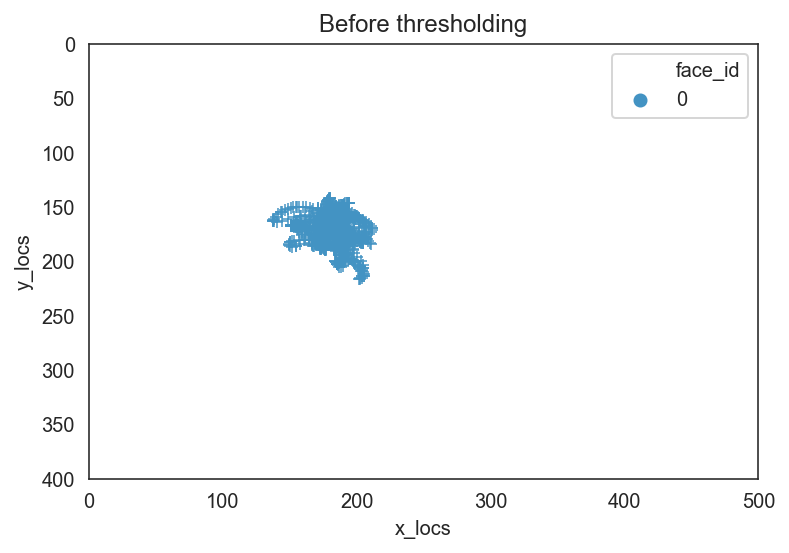

In [7]:
import re
x_regex_pat = re.compile(r'^x_[0-9]+$')
y_regex_pat = re.compile(r'^y_[0-9]+$')
x_locs = df.columns[df.columns.str.contains(x_regex_pat)]
y_locs = df.columns[df.columns.str.contains(y_regex_pat)]
palette = sns.color_palette("RdBu_r", 4)

avg_face_df = pd.DataFrame({'x_locs':df[x_locs].mean(axis=1), 'y_locs':df[y_locs].mean(axis=1), 'face_id': df.face_id})
ax = sns.scatterplot(x='x_locs', y='y_locs', hue = 'face_id', data=avg_face_df, marker="+", palette=palette[:1])
ax.set(xlim=[0, 500], ylim=[400,0], title="Before thresholding");


* Above Visualization indicates the average gaze direction of the person throughout the video

List of AU columns: Index(['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r'],
      dtype='object')


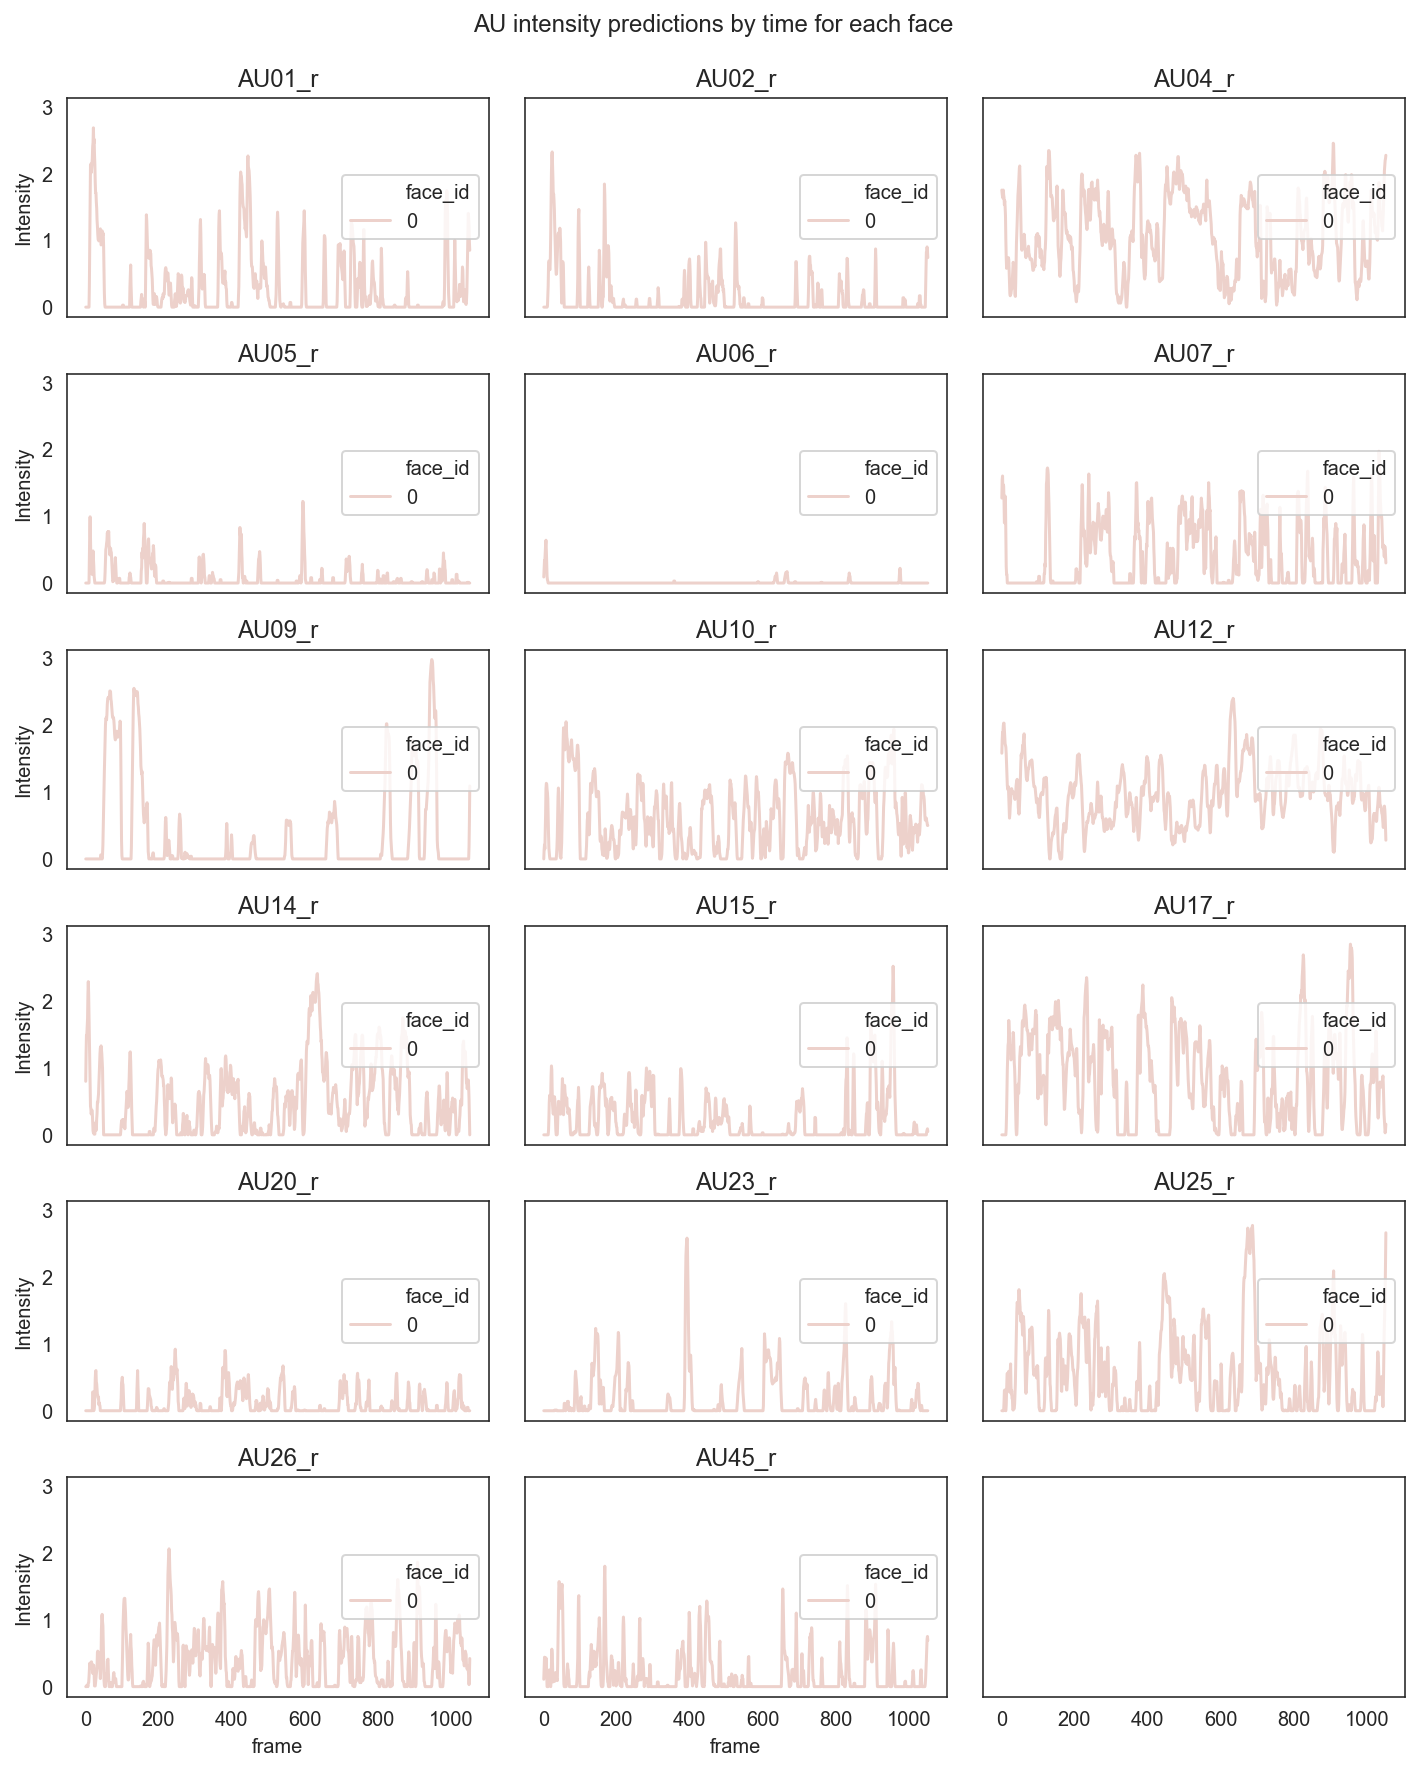

In [0]:
# Threshold data by 80%
df_clean = df[df.confidence>=.80]
# Plot all Action Unit time series. 
au_regex_pat = re.compile(r'^AU[0-9]+_r$')
au_columns = df.columns[df.columns.str.contains(au_regex_pat)]
print("List of AU columns:", au_columns)
f,axes = plt.subplots(6, 3, figsize=(10,12), sharex=True, sharey=True)
axes = axes.flatten()
for au_ix, au_col in enumerate(au_columns):
    sns.lineplot(x='frame', y=au_col, hue='face_id', data=df_clean, ax=axes[au_ix])
    axes[au_ix].set(title=au_col, ylabel='Intensity')
    axes[au_ix].legend(loc=5)
plt.suptitle("AU intensity predictions by time for each face", y=1.02)
plt.tight_layout()

* An Intensity v/s Frame line plot is plotted for every AU we obtained from the video. The graphs show varying values of intensities of the AU's over time.
* Detailed list of the FAC: https://imotions.com/blog/facial-action-coding-system/

In [0]:
import glob
def create_data_df(data_path):
    '''
    Returns Dataframe which has the facial feature and text data concatted horizontally at timestamps of utterance levels
    '''
   
    df_v = pd.DataFrame()
    for f in glob.glob(data_path):
        print('Video :',f)
        df_name_temp = pd.read_csv(f,sep=';')
        if 'Speech' not in df_name_temp.columns:
            df_name_temp['Speech'] = ''    
        if 'speech' in df_name_temp.columns:
            df_name_temp['Speech'] = df_name_temp[['Speech','speech']].fillna('').sum(axis=1)   
        if 'transcription' in df_name_temp.columns:
            df_name_temp['Speech'] = df_name_temp[['Speech','transcription']].fillna('').sum(axis=1)
        if 'sentimentAnnotation' not in df_name_temp.columns:
            df_name_temp['sentimentAnnotation'] = 0    
        if 'sentimentAnnotations' in df_name_temp.columns:
            df_name_temp['sentimentAnnotation'] = df_name_temp[['sentimentAnnotation','sentimentAnnotations']].fillna(0).sum(axis=1)
        if 'sentimentannotations' in df_name_temp.columns:
            df_name_temp['sentimentAnnotation'] = df_name_temp[['sentimentAnnotation','sentimentannotations']].fillna(0).sum(axis=1)
        
        df_name_temp = df_name_temp.query('sentimentAnnotation != 0')
        #df_name_temp = df_name_temp.query('sentimentAnnotations != 0')
         
        # Creating a df of the corredponding OpenFace features file 
        v_name = r"C:\\Users\\Niraj\\Downloads\\MOUD\\MOUD\\VideoReviews\\file_csv\\content\\csv_vid" + "\\" + f.rsplit("\\",1)[1].split(".")[0] + ".mp4.csv"
        df_v_name = pd.read_csv(v_name, sep = ", ", engine = "python")
    
        # Splitting the video data by utterances
        #df_v_name_2 = pd.DataFrame()
        for starttime,endtime,sentiment,text in zip(df_name_temp['#starttime'],df_name_temp['#endtime'],df_name_temp['sentimentAnnotation'],df_name_temp['Speech']):    
            df_v_name_temp = df_v_name.query('timestamp >='+str(starttime)+'& timestamp <='+str(endtime)).agg(['mode'])
            df_v_name_temp.drop(['frame','timestamp','confidence','success'], axis = 1)
            #print('check',df_name_temp['sentimentAnnotations'])
            df_v_name_temp['Sentiment'] = sentiment
            df_v_name_temp['Speech'] = text
            df_v = df_v.append(df_v_name_temp,ignore_index=True)
    return df_v

In [0]:
df_v = create_data_df('C:\\Users\\Niraj\\Downloads\\MOUD\\MOUD\\VideoReviews\\transcriptions\\*.csv')

Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\100_makeup.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\101_movies.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\102_books.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\103_books.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\104_makeup.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\105_makeup.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\107_makeup.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\108_makeup.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\109_books.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\110_perfume.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\transcriptions\111_makeup.csv
Video : C:\Users\Niraj\Downloads\MOUD\MOUD\VideoReviews\

In [35]:
#df_v2 = df_v.copy()
df_v2 = pd.read_csv('text_vid.csv')

In [36]:
a = list(df_v2.columns)
a.remove('frame')
a.remove('face_id')
a.remove('timestamp')
a.remove('confidence')
a.remove('success')
a.remove('Unnamed: 0')

In [32]:
df_v2 = df_v2[a]
df_v2 = df_v2.dropna()
df_v2 = df_v2.reset_index(drop=True)

In [24]:
df_v2

gaze_0_x  gaze_0_y  gaze_0_z  gaze_1_y  gaze_angle_x  gaze_angle_y  \
0    0.145450  0.170115 -0.974484  0.172503      0.061809      0.173155   
1    0.099163  0.153723 -0.933477  0.146968      0.019034      0.152119   
2    0.098964  0.185781 -0.976576  0.183415      0.013647      0.186590   
3    0.103902  0.192929 -0.975292  0.206512      0.018221      0.201947   
4    0.150879  0.179160 -0.971641  0.188906      0.067524      0.186244   
..        ...       ...       ...       ...           ...           ...   
444 -0.328154  0.132395 -0.925835  0.100599     -0.425922      0.131116   
445 -0.226710  0.085331 -0.963268  0.059933     -0.319141      0.078828   
446 -0.270997  0.094305 -0.949875  0.086060     -0.364181      0.100339   
447 -0.242528  0.081648 -0.953250  0.073846     -0.338109      0.088177   
448 -0.236864  0.082389 -0.904514  0.072781     -0.329272      0.088728   

     eye_lmk_x_0  eye_lmk_x_1  eye_lmk_x_3  eye_lmk_x_5  ...    AU01_c  \
0     150.246364   151.243636   156.100909   156.305455  ...  0.000000   
1     152.398305   153.537853   158.303955   158.159322  ...  0.355932   
2     151.767626   152.834532   157.660432   157.701439  ...  0.028777   
3     147.027368   147.827895   152.492105   153.024737  ...  0.000000   
4     151.021951   151.925610   156.825610   157.243902  ...  0.000000   
..           ...          ...          ...          ...  ...       ...   
444   271.614729   273.990698   281.431008   279.996124  ...  0.279070   
445   259.886458   261.963021   269.569271   268.816146  ...  0.354167   
446   250.674016   252.403150   259.748031   259.593701  ...  0.614173   
447   246.076604   247.777736   255.133208   255.046792  ...  0.083019   
448   240.446552   242.106466   249.057328   248.887069  ...  0.051724   

       AU10_c    AU12_c    AU14_c    AU20_c    AU23_c    AU25_c    AU26_c  \
0    0.000000  0.000000  0.072727  0.036364  0.000000  0.009091  0.072727   
1    0.000000  0.000000  0.000000  0.107345  0.000000  0.395480  0.395480   
2    0.043165  0.071942  0.517986  0.237410  0.000000  0.446043  0.230216   
3    0.000000  0.000000  0.015789  0.526316  0.000000  0.178947  0.026316   
4    0.000000  0.000000  0.000000  0.121951  0.000000  0.280488  0.195122   
..        ...       ...       ...       ...       ...       ...       ...   
444  0.860465  0.511628  0.379845  0.015504  0.000000  0.248062  0.062016   
445  0.708333  0.130208  0.125000  0.000000  0.020833  0.479167  0.380208   
446  0.637795  0.039370  0.110236  0.094488  0.000000  0.275591  0.149606   
447  0.694340  0.358491  0.396226  0.154717  0.033962  0.516981  0.283019   
448  0.646552  0.314655  0.422414  0.064655  0.038793  0.297414  0.116379   

     AU28_c  Sentiment  
0       0.0         -1  
1       0.0         -1  
2       0.0         -1  
3       0.0         -1  
4       0.0          1  
..      ...        ...  
444     0.0          1  
445     0.0          1  
446     0.0         -1  
447     0.0          1  
448     0.0          1  

[449 rows x 424 columns]

In [0]:
def plot_roc_auc(model,X_test,y_test,label):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    #print(lr_probs)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    #print(lr_probs)
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=label)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()# show the plot
    plt.show()

## Logistic Regression

In [25]:
# Import the logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the vector of targets and matrix of features
y = df_v2.Sentiment
X = df_v2.drop('Sentiment', axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build a logistic regression model and print out the accuracy
log_reg = LogisticRegression(max_iter=100000).fit(X_train, y_train)
print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', log_reg.score(X_test, y_test))

# Make predictions on the test set
y_predicted = log_reg.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on train set:  0.8746518105849582
Accuracy on test set:  0.8
Accuracy score test set:  0.8
Confusion matrix test set: 
 [[0.44444444 0.11111111]
 [0.08888889 0.35555556]]


C:\Users\Niraj\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


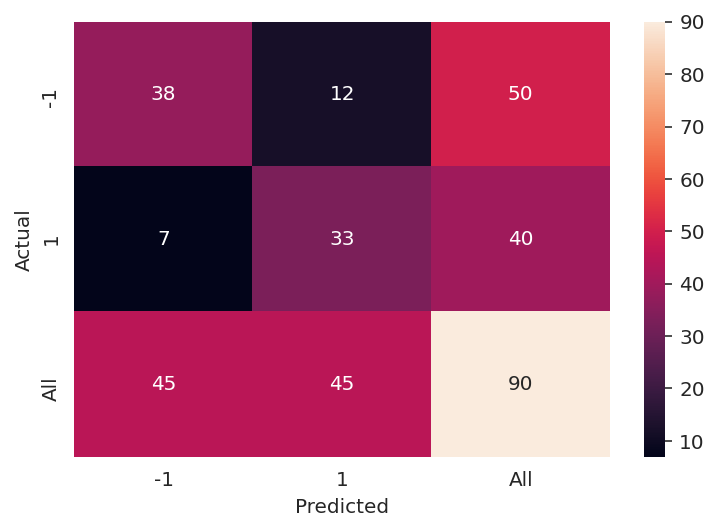

In [0]:
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.844


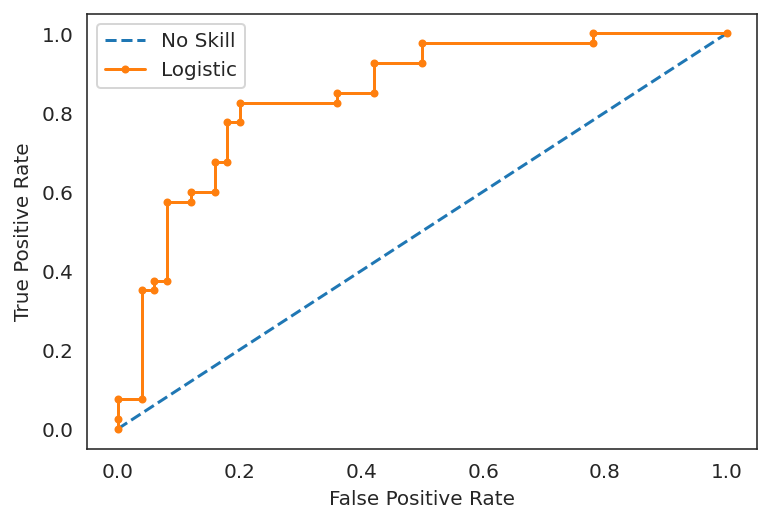

In [0]:
plot_roc_auc(log_reg,X_test,y_test,'Logistic')

## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Build a logistic regression model and print out the accuracy
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
print('Accuracy on train set: ', clf.score(X_train, y_train))
print('Accuracy on test set: ', clf.score(X_test, y_test))

# Make predictions on the test set
y_predicted = clf.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))


Accuracy on train set:  1.0
Accuracy on test set:  0.6777777777777778
Accuracy score test set:  0.6777777777777778


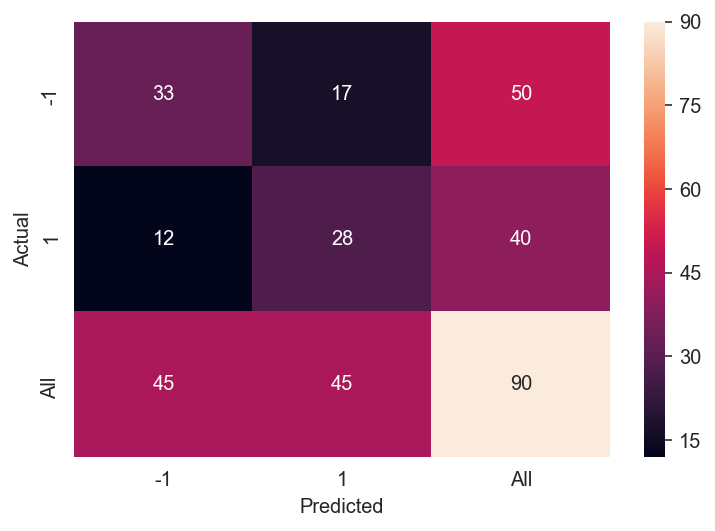

In [0]:
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.680


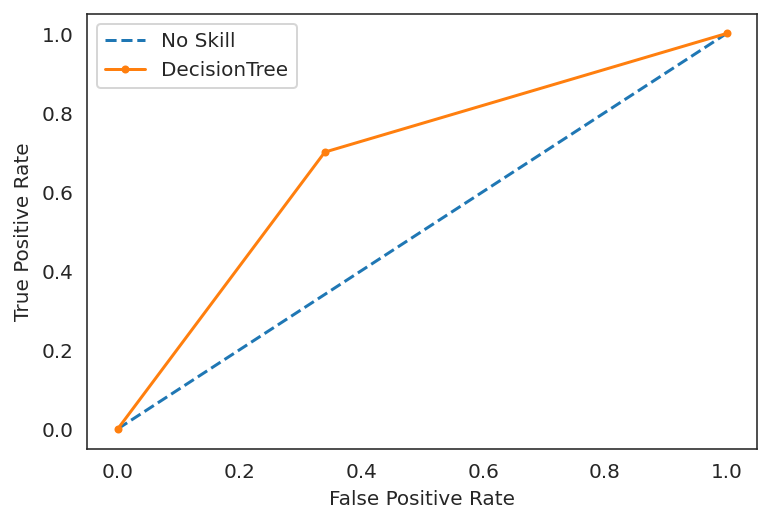

In [0]:
plot_roc_auc(clf,X_test,y_test,'DecisionTree')

## SVC

In [0]:
from sklearn import svm
from sklearn.metrics import confusion_matrix



#Create a svm Classifier
clf = svm.SVC(kernel='linear',probability=True) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_predicted = clf.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy score test set:  0.7111111111111111
Confusion matrix test set: 
 [[0.41111111 0.14444444]
 [0.14444444 0.3       ]]


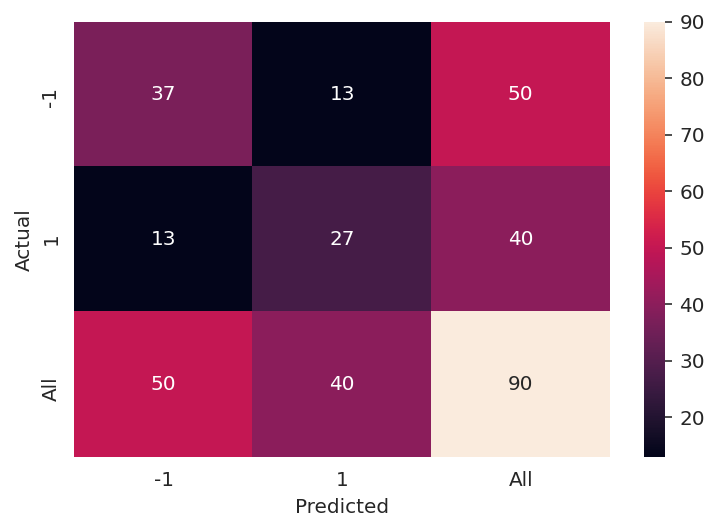

In [0]:
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.791


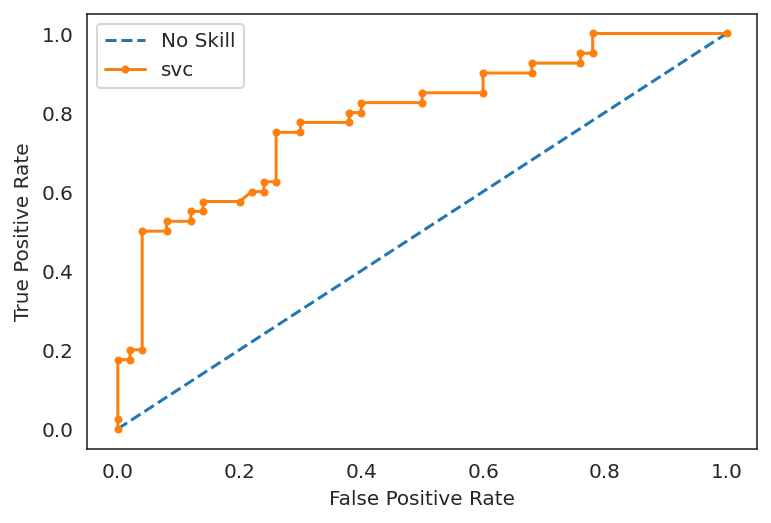

In [0]:
plot_roc_auc(clf,X_test,y_test,'svc')

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
predictions = []
#Create Model
for i in range(100):
  model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
  # Fit on training data
  model.fit(X_train,y_train)
  #Predict the response for test dataset
  y_predicted2 = model.predict(X_test)
  predictions.append(y_predicted2)

result = []
from collections import Counter
for i in range(len(y_predicted2)):
    a = []
    for j in range(100):
      a.append(predictions[j][i])
    #print(a)
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    





# Print the performance metrics
print('Accuracy score test set: ',accuracy_score(y_test, result))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))


Accuracy score test set:  0.8444444444444444
Confusion matrix test set: 
 [[0.46666667 0.08888889]
 [0.08888889 0.35555556]]


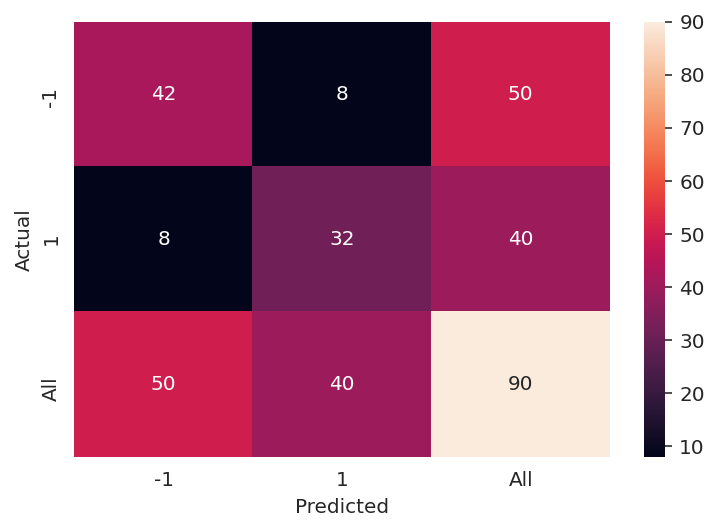

In [0]:
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.921


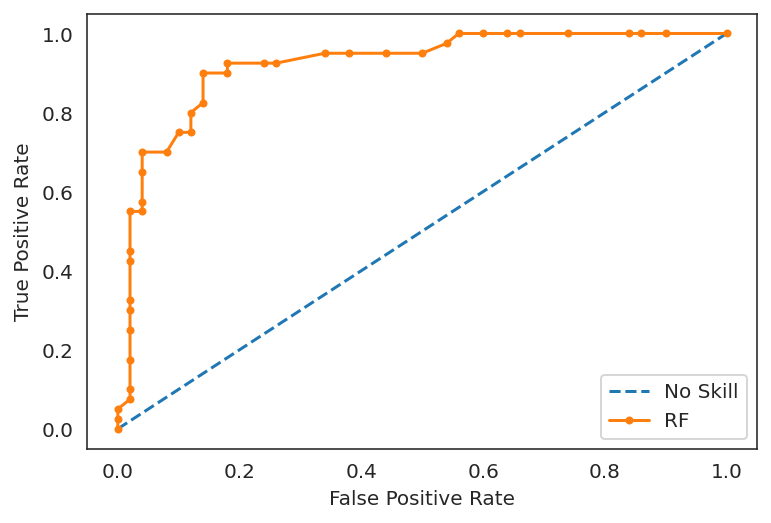

In [0]:
plot_roc_auc(model,X_test,y_test,'RF')

## XGBoost

In [27]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix

# Define the vector of targets and matrix of feature
# XGB Classifier
xg_model = XGBClassifier()

#Train XGB Model
xg_model.fit(X_train,y_train)

#Predict the response for test dataset
y_predicted = xg_model.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))



Accuracy score test set:  0.8111111111111111
Confusion matrix test set: 
 [[0.44444444 0.11111111]
 [0.07777778 0.36666667]]


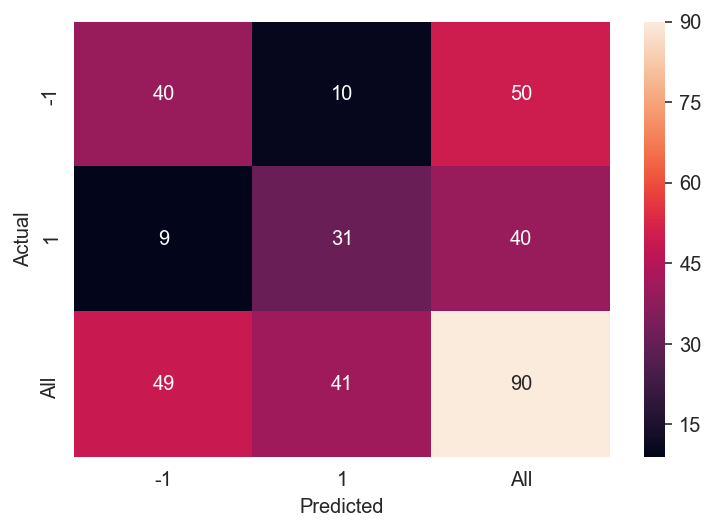

In [0]:
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.888


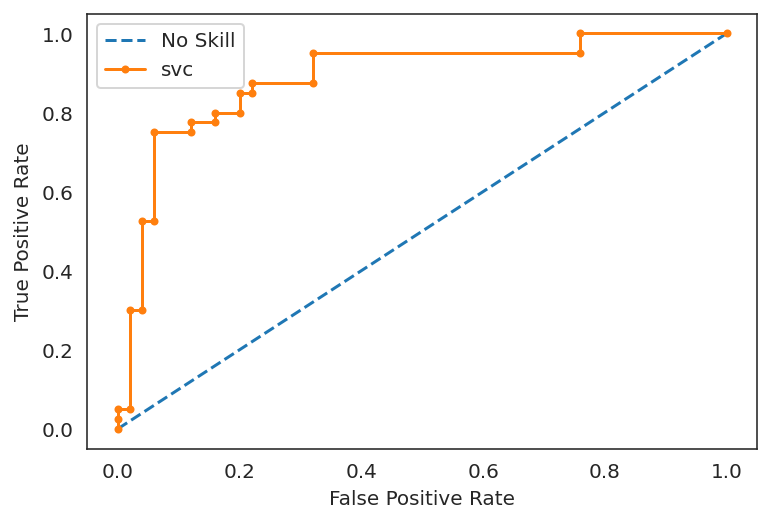

In [0]:
plot_roc_auc(xg_model,X_test,y_test,'svc')

## Performing Feature Selection

In [0]:
!pip install hyperactive

     |████████████████████████████████| 61kB 2.3MB/s 


In [0]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from hyperactive import Hyperactive
from xgboost import XGBClassifier


def pca(X):
    X = PCA(n_components=359).fit_transform(X)

    return X


def none(X):
    return X


def model(para, X, y):
    model = RandomForestClassifier(
        n_estimators=para["n_estimators"],
        max_depth=para["max_depth"],
        min_samples_split=para["min_samples_split"],
        min_samples_leaf=para["min_samples_leaf"],
    )
    X_pca = para["decomposition"](X)
    X = np.hstack((X, X_pca))

    X = SelectKBest(f_classif, k=para["k"]).fit_transform(X, y)
    scores = cross_val_score(model, X, y, cv=3)

    return scores.mean()


search_config = {
    model: {
        "decomposition": [pca, none],
        "k": range(2, 30),
        "n_estimators": range(10, 200, 10),
        "max_depth": range(2, 12),
        "min_samples_split": range(2, 12),
        "min_samples_leaf": range(1, 11),
    }
}


opt = Hyperactive(np.ascontiguousarray(X_train.to_numpy(), dtype=np.float32),np.ascontiguousarray(y_train.to_numpy(), dtype=np.float32))
opt.search(search_config, optimizer="ParticleSwarm",n_iter=200)

No meta data found for model function
Set random start position



best para = {'decomposition': <function pca at 0x7fbea441db70>, 'k': 25, 'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}
score     = 0.7215919701213819 



In [0]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperactive import Hyperactive



def model(para, X, y):
    xgb = XGBClassifier(
        n_estimators=para["n_estimators"],
        max_depth=para["max_depth"],
        learning_rate=para["learning_rate"],
    )
    scores = cross_val_score(xgb, X, y, cv=3)

    return scores.mean()


search_config = {
    model: {
        "n_estimators": range(10, 200, 10),
        "max_depth": range(2, 12),
        "learning_rate": [1e-3, 1e-2, 1e-1, 0.5, 1.0],
    }
}


opt = Hyperactive(np.ascontiguousarray(X_train.to_numpy(), dtype=np.float32),np.ascontiguousarray(y_train.to_numpy(), dtype=np.float32))
opt.search(search_config, optimizer="ParticleSwarm",n_iter=100)

No meta data found for model function
Set random start position



best para = {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.1}
score     = 0.7716386554621848 



In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=449)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)  

In [16]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.2, random_state=42, stratify=y)

# Build a logistic regression model and print out the accuracy
log_reg = LogisticRegression(max_iter=100000).fit(X_train, y_train)
print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', log_reg.score(X_test, y_test))

# Make predictions on the test set
y_predicted0 = log_reg.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted0))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on train set:  0.8941504178272981
Accuracy on test set:  0.8111111111111111
Accuracy score test set:  0.8111111111111111
Confusion matrix test set: 
 [[0.42222222 0.13333333]
 [0.07777778 0.36666667]]


In [17]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix

# Define the vector of targets and matrix of feature
# XGB Classifier
xg_model = XGBClassifier()

#Train XGB Model
xg_model.fit(X_train,y_train)

#Predict the response for test dataset
y_predicted = xg_model.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

C:\Users\Niraj\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Accuracy score test set:  0.7555555555555555
Confusion matrix test set: 
 [[0.51111111 0.04444444]
 [0.2        0.24444444]]


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
predictions = []
#Create Model
for i in range(100):
  model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
  # Fit on training data
  model.fit(X_train,y_train)
  #Predict the response for test dataset
  y_predicted2 = model.predict(X_test)
  predictions.append(y_predicted2)

result = []
from collections import Counter
for i in range(len(y_predicted2)):
    a = []
    for j in range(100):
      a.append(predictions[j][i])
    #print(a)
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    





# Print the performance metrics
print('Accuracy score test set: ',accuracy_score(y_test, result))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy score test set:  0.6444444444444445
Confusion matrix test set: 
 [[0.51111111 0.04444444]
 [0.2        0.24444444]]


In [35]:
X_train

0            1           2    ...       312       313       314
319  -989.868874   262.391950  532.914455  ... -0.002378  0.005620  0.000586
140  2263.250729 -1515.407822  -97.593447  ... -0.008070 -0.002003 -0.005251
94     50.377775  -609.003485  836.046210  ... -0.004510 -0.000064 -0.000612
287  3292.001422  1476.909333   18.942232  ...  0.002950  0.001881  0.003603
395 -1188.340857  -937.141613 -569.956058  ...  0.000355 -0.002981 -0.002992
..           ...          ...         ...  ...       ...       ...       ...
238   328.976302    10.091259   -6.674430  ... -0.002317  0.004177 -0.001016
392   468.613749  -355.087856  421.569365  ... -0.000004  0.003191  0.000049
246  1732.540111    53.160495   71.457641  ... -0.002975  0.001486  0.002191
233   357.865292  -260.392319  -23.335481  ...  0.003271 -0.002477 -0.011434
48   -329.787834  -449.699116  132.539597  ... -0.002230 -0.005855 -0.002224

[359 rows x 315 columns]

### Logistic Regression

In [0]:
# Create two instances of LogisticRegression
classfier = linear_model.LogisticRegression()

# Get the selected features from the final positions
X_selected_features = X.iloc[:,pos==1]  # subset

# Perform classification and store performance in P
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.2, random_state=42, stratify=y)

classifier.fit(X_train, y_train)

# Compute performance
y_predicted = classifier.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))



Accuracy score test set:  0.7888888888888889


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.848


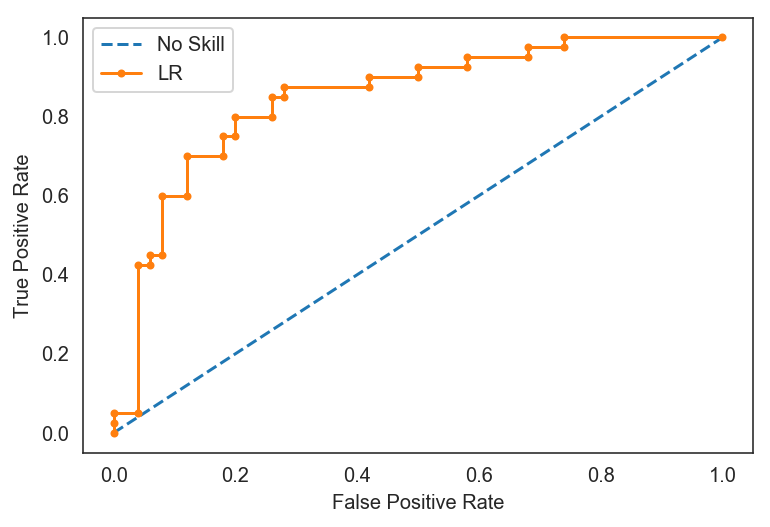

In [0]:
plot_roc_auc(classifier,X_test,y_test,'LR')

### XGBoost

In [0]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix

# Define the vector of targets and matrix of feature
# XGB Classifier
xg_model = XGBClassifier()

#Train XGB Model
xg_model.fit(X_train,y_train)

#Predict the response for test dataset
y_predicted = xg_model.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))


Accuracy score test set:  0.8111111111111111
Confusion matrix test set: 
 [[0.44444444 0.11111111]
 [0.07777778 0.36666667]]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.885


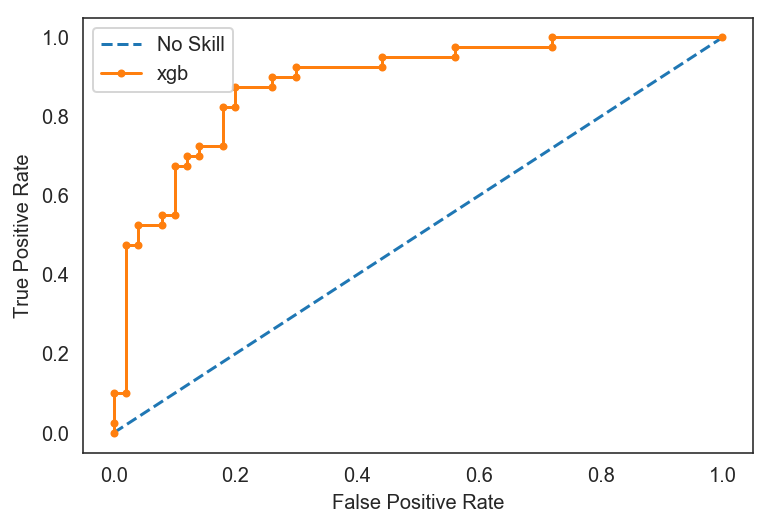

In [0]:
plot_roc_auc(xg_model,X_test,y_test,'xgb')

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#Create Model
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train,y_train)

#Predict the response for test dataset
y_predicted = model.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy score test set:  0.8555555555555555
Confusion matrix test set: 
 [[0.48888889 0.06666667]
 [0.07777778 0.36666667]]


In [0]:
X_selected_features['Sentiment'] = y

In [0]:
X_selected_features.to_csv('filtered_feature.csv')

### DeepTable Test

In [0]:
# Import the logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the vector of targets and matrix of features
y = df_v2.Sentiment
X = df_v2.drop('Sentiment', axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build a logistic regression model and print out the accuracy
log_reg = LogisticRegression().fit(X_train, y_train)
print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', log_reg.score(X_test, y_test))

# Make predictions on the test set
y_predicted = log_reg.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

C:\Users\Niraj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on train set:  0.8941504178272981
Accuracy on test set:  0.8111111111111111
Accuracy score test set:  0.8111111111111111
Confusion matrix test set: 
 [[0.44444444 0.11111111]
 [0.07777778 0.36666667]]


In [0]:
from __future__ import print_function
import numpy as np
from sklearn import datasets, linear_model

from genetic_selection import GeneticSelectionCV
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix

# Define the vector of targets and matrix of feature
# XGB Classifier
xg_model = XGBClassifier()
estimator = linear_model.LogisticRegression(solver="liblinear")

selector = GeneticSelectionCV(xg_model,
                                  cv=5,
                                  verbose=1,
                                  scoring="accuracy",
                                  max_features=700,
                                  n_population=50,
                                  crossover_proba=0.5,
                                  mutation_proba=0.2,
                                  n_generations=40,
                                  crossover_independent_proba=0.5,
                                  mutation_independent_proba=0.05,
                                  tournament_size=3,
                                  n_gen_no_change=10,
                                  caching=True,
                                  n_jobs=-1)
selector = selector.fit(X_train, y_train)

print(selector.support_)


Selecting features with genetic algorithm.


In [0]:
X_train.shape,X_test.shape
X_train.shape,X_test.shape


((359, 709), (90, 709))

In [0]:
print('Accuracy on test set: ', selector.score(X_test, y_test))

Accuracy on test set:  0.7888888888888889


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbm=GradientBoostingClassifier(random_state=42)
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[5,10,15]
    }
grid_search_gbm = GridSearchCV(gbm,param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc')


# Fit the grid search to the data
grid_search_gbm.fit(X_train, y_train)

grid_search_gbm.fit(X_train, y_train)
print(grid_search_gbm.best_params_)

best_grid_gbm = grid_search_gbm.best_estimator_

C:\Users\Niraj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Niraj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 15}


In [0]:
import numpy as np

In [0]:
from sklearn.metrics import *
y_pred_gbm = best_grid_gbm.predict(X_train)
y_pred_gbmt = best_grid_gbm.predict(X_test)


print ("\n\n The accuracy score for test data is : ", accuracy_score(y_test, y_pred_gbmt))




 The accuracy score for test data is :  0.8
